In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import json
#import seaborn as sns
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

### Importing catalog data from CSV (FRBCat) and JSON (CHIME repeaters)

In [3]:
frbs_cat = pd.read_csv('./catalog/frbcat_20210519_all.csv') #rel path
#frbs = pd.read_csv('/home/jthwaites/frbcat_20210212.csv') #abs path

print(frbs_cat.shape)
frbs_cat.head() #Look at what the dataframe looks like
#frbs_cat.columns #list of columns from csv
#'frb_name', 'utc', 'telescope', 'rop_raj', 'rop_decj', 'rop_gl',
#       'rop_gb', 'rmp_dm', 'rmp_width', 'rmp_snr', 'rmp_flux'

(191, 9)


,frb_name,utc,telescope,rop_raj,rop_decj,rmp_dm,rmp_width,rmp_snr,rmp_flux
0,FRB20200125A,2020/01/25 12:15:19.600,GBT,14:36:31.580,+07:42:06.84,179.47&plusmn0.05,3.70,8.10,0.368
1,FRB20190614D,2019/06/14 01:13:02.010,VLA,04:20:18.130,+73:42:24.3,959.2&plusmn5,5.00,8.27,0.124
2,FRB191108,2019/11/08 19:48:50.471,Apertif,01:33:47.000,+31:51:30,588.1&plusmn0.1,0.34,103.00,27.000
3,FRB190907.J08+46,2019/09/07 17:02:43.311,CHIME/FRB,08:09:00.000,+46:16,310.9&plusmn0.4,3.00,0.00,0.300
4,FRB190907.J08+46,2019/09/15 16:27:37.000,CHIME/FRB,08:09:00.000,+46:16,309.5&plusmn0.4,0.54,0.00,0.400


In [4]:
with open('./catalog/repeaters.txt') as json_file:
    repeaters = json.load(json_file)
#print(repeaters.keys())

In [5]:
#making data arrays that are easier to work with: source names and n_bursts
rep_num={'source':[],'n_bursts':[]}
ra_dec=[[],[]]
for source in repeaters:
    ra_dec[0].append(repeaters[source]['ra']['value'])
    ra_dec[1].append(repeaters[source]['dec']['value'])
    
    count=0
    for key in repeaters[source]:
        if key != 'dm' and key !='ymw16' and key!='dec' and key!='gl' and key!='gb' and key!= 'ra' and \
            key!='localized' and key!='last_burst_date' and key!='publication' and key!='ne2001' and \
            key!='previous_name': 
            count+=1
            
    rep_num['source'].append(source)
    rep_num['n_bursts'].append(count)
    
#coordinates of repeaters as skycoord obj
rep_coord=SkyCoord(ra=ra_dec[0], dec=ra_dec[1], unit=(u.hourangle, u.deg))
#for i in range(len(rep_num['source'])):
#    print(rep_num['source'][i], rep_num['n_bursts'][i],rep_coord[i])
print(rep_num['source'])

['190907.J08+46', 'FRB20180814A', 'FRB20180908B', 'FRB20180916B', 'FRB20181017A', 'FRB20181030B', 'FRB20181119A', 'FRB20181128A', 'FRB20190116B', 'FRB20190117A', 'FRB20190208A', 'FRB20190209A', 'FRB20190212A', 'FRB20190213A', 'FRB20190222A', 'FRB20190303A', 'FRB20190417A', 'FRB20190604A']


In [6]:
frbs_rep=pd.DataFrame.from_dict(data=rep_num)

In [7]:
#counting repeater events and getting repeater mjd array
rep_utc=[]
for source in repeaters:
    for event in repeaters[source].keys():
        if 'timestamp' in repeaters[source][event].keys():
            rep_utc.append(repeaters[source][event]['timestamp']['value'])
frbs_rep_mjd = np.asarray([Time(t, format='iso').mjd for t in rep_utc])
print('Number of repeater events: ',len(frbs_rep_mjd))
print(repeaters['190907.J08+46']['190907']['timestamp']['value'])

Number of repeater events:  172
2019-09-07 17:02:43.311


#### reading in Chime catalog 1

In [12]:
chime_cat1 = pd.read_csv('./catalog/chimefrbcat1.csv') #rel path

print(chime_cat1.shape)
chime_cat1.columns

(599, 55)


Index(['tns_name', 'previous_name', 'repeater_name', 'ra', 'ra_err',
       'ra_notes', 'dec', 'dec_err', 'dec_notes', 'gl', 'gb', 'exp_up',
       'exp_up_err', 'exp_up_notes', 'exp_low', 'exp_low_err', 'exp_low_notes',
       'bonsai_snr', 'bonsai_dm', 'low_ft_68', 'up_ft_68', 'low_ft_95',
       'up_ft_95', 'snr_fitb', 'dm_fitb', 'dm_fitb_err', 'dm_exc_ne2001',
       'dm_exc_ymw16', 'bc_width', 'scat_time', 'scat_time_err', 'flux',
       'flux_err', 'flux_notes', 'fluence', 'fluence_err', 'fluence_notes',
       'sub_num', 'mjd_400', 'mjd_400_err', 'mjd_inf', 'mjd_inf_err',
       'width_fitb', 'width_fitb_err', 'sp_idx', 'sp_idx_err', 'sp_run',
       'sp_run_err', 'high_freq', 'low_freq', 'peak_freq', 'chi_sq', 'dof',
       'flag_frac', 'excluded_flag'],
      dtype='object')

In [13]:
cat1_times=[Time('2018-07-25 00:00:00', format='iso').mjd, Time('2019-07-01 00:00:00', format='iso').mjd]
remove_rep_duplicates=[]
for i in range(len(chime_cat1['repeater_name'])):
    name=chime_cat1['repeater_name'][i]
    if chime_cat1['previous_name'][i]== '190907.J08+46' or chime_cat1['previous_name'][i]== 'FRB121102':
        chime_cat1['tns_name'][i]=chime_cat1['previous_name'][i]
    if chime_cat1['tns_name'][i] in rep_num['source']:
        if chime_cat1['mjd_400'][i]>cat1_times[0] and chime_cat1['mjd_400'][i]<cat1_times[1]:
            remove_rep_duplicates.append(i)
            
msk_1=cat1_times[0]<frbs_rep_mjd
msk_2=cat1_times[1]>frbs_rep_mjd
chime_cat1=chime_cat1.drop(remove_rep_duplicates)
len(chime_cat1)

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


578

In [14]:
#for src in rep_num['source']:
#src=rep_num['source'][1]
#w=np.where(src==chime_cat1['repeater_name'])
#print([(chime_cat1['mjd_400'][j],chime_cat1['mjd_400_err'][j]) for j in w])

#utc=[]
#if w[0].size != 0: 
#    for event in repeaters[src].keys():
#        if 'timestamp' in repeaters[src][event].keys():
#            utc.append(repeaters[src][event]['timestamp']['value'])
#utc = np.asarray([Time(t, format='iso').mjd for t in utc])
#print(chime_cat1['mjd_400'][33])
#print(chime_cat1['mjd_400'][34])


In [15]:
#FRBs from 6-yr analysis (transient tracks)
msk1=frbs_cat['frb_name']=='FRB110523'
msk2=frbs_cat['frb_name']=='FRB110703'
msk3=frbs_cat['frb_name']=='FRB121102' #repeater
msk4=frbs_cat['frb_name']=='FRB130628'
msk5=frbs_cat['frb_name']=='FRB110220'
#msk6=frbs_cat['frb_name']=='FRB110626' #->returns none
msk7=frbs_cat['frb_name']=='FRB120127'
msk8=frbs_cat['frb_name']=='FRB121002'
msk9=frbs_cat['frb_name']=='FRB130626'
msk10=frbs_cat['frb_name']=='FRB130729'
msk11=frbs_cat['frb_name']=='FRB131104'
msk12=frbs_cat['frb_name']=='FRB140514'
msk13=frbs_cat['frb_name']=='FRB150418'

w121102=np.where(msk3==True)
msk=msk1|msk2|msk4|msk3|msk5|msk7|msk8|msk9|msk10|msk11|msk12|msk13
#msk=msk1|msk2|msk4|msk3|msk5|msk6|msk7|msk8|msk9|msk10|msk11|msk12|msk13
np.where(msk==True)

(array([147, 151, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178,
        179, 180, 182, 183]),)

In [16]:
#FRBs from 2020 paper
msk14=frbs_cat['frb_name']=='FRB110626'
msk15=frbs_cat['frb_name']=='FRB150215'
msk16=frbs_cat['frb_name']=='FRB150610'
msk17=frbs_cat['frb_name']=='FRB150807'
msk18=frbs_cat['frb_name']=='FRB151206'
msk19=frbs_cat['frb_name']=='FRB151230'
msk20=frbs_cat['frb_name']=='FRB160102'
msk21=frbs_cat['frb_name']=='FRB160317'
msk22=frbs_cat['frb_name']=='FRB160410'
msk23=frbs_cat['frb_name']=='FRB160608'
msk24=frbs_cat['frb_name']=='FRB170107'
msk25=frbs_cat['frb_name']=='FRB170827'
msk26=frbs_cat['frb_name']=='FRB170922'
msk27=frbs_cat['frb_name']=='FRB171209'
#msk28=frbs_cat['frb_name']=='FRB180301'
msk29=frbs_cat['frb_name']=='FRB180309'
msk30=frbs_cat['frb_name']=='FRB180311'

new_msk=msk|msk14|msk15|msk16|msk17|msk18|msk19|msk20|msk21|msk22|msk23|msk24|msk25|msk26|msk27|msk29|msk30
np.where(new_msk==True)

(array([107, 108, 118, 124, 126, 132, 135, 136, 137, 139, 140, 141, 145,
        146, 147, 148, 151, 153, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 178, 179, 180, 182, 183]),)

In [17]:
#CHIME repeaters: remove repeaters from FRBCat to not double-count events
chimes=np.where(frbs_cat['telescope']=='CHIME/FRB')
frbcheck=[] #names from frbcat
for n in chimes[0]:
    frbcheck.append(frbs_cat['frb_name'][n][0:9])
    
frbcat_format=''
rem=[[],[]]
for source in rep_num['source']:
    if source[0:3]=='FRB':
        frbcat_format=source[0:3]+source[5:-1]
    else:
        frbcat_format='FRB'+source[0:6]
    
    res = any(ele in frbcat_format for ele in frbcheck)
    if bool(res) == 1:
        rem[0].append(frbcheck[frbcheck.index(frbcat_format)])
    
print('Initial number of FRBs in FRBCat: ',len(frbs_cat))

for ind in range(len(frbs_cat['frb_name'])):
    res = any(ele in frbs_cat['frb_name'][ind] for ele in rem[0])
    if bool(res)==1:
        rem[1].append(ind)
frbs=frbs_cat.drop(rem[1])
print('Number of FRBs from FRBCat, w/out CHIME repeaters: ',len(frbs))
print('Number removed: ',len(rem[1]))

Initial number of FRBs in FRBCat:  191
Number of FRBs from FRBCat, w/out CHIME repeaters:  118
Number removed:  73


In [18]:
#saving all sources as csv file
frbs.to_csv('./catalog/frbs_wout_chime.csv',index=False)

In [19]:
#still have some which are repeaters from frbcat -> seperate these to not double count the ra,dec
rep_ind = []

#for i in frbs['frb_name'].index:
#    if frbs['frb_name'][i] in frbs['frb_name'].values: print(i)
    
unique_frbs, frb_ind_all, n_frbs = np.unique(frbs['frb_name'].values, return_index=True, return_counts=True)
frb_ind_all=frbs['frb_name'].index[frb_ind_all]
print('N unique FRBs: ',len(frb_ind_all))

N unique FRBs:  98


In [20]:
#convert to mjd, switch to iso format
frbs_mjd = np.asarray([Time(t.replace('/', '-'), format='iso').mjd for t in frbs['utc']]) 
frbs_flux= frbs['rmp_flux']

In [21]:
#frbs['rop_decj'].reindex(frb_ind_all).values
frbs_coord = SkyCoord(ra=frbs['rop_raj'].reindex(frb_ind_all).values, 
                      dec=frbs['rop_decj'].reindex(frb_ind_all).values, 
                      unit=(u.hourangle, u.deg))

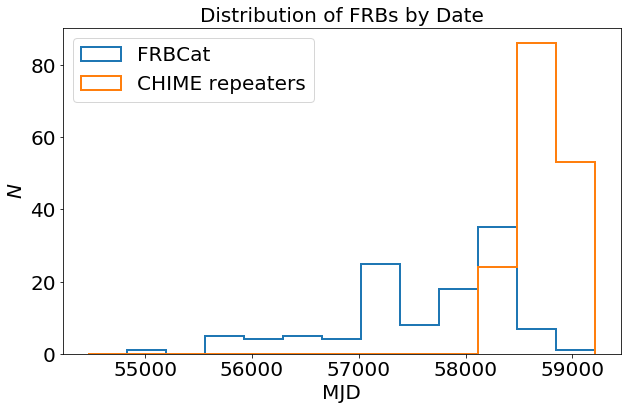

In [22]:
year_bins = [Time(f'20{year:02d}-01-01 00:00:00', format='iso').mjd for year in range(8, 22)]

#dates hist
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(frbs_mjd, bins=year_bins, histtype='step', lw=2., label='FRBCat')
plt.hist(frbs_rep_mjd, bins=year_bins, histtype='step', lw=2., label='CHIME repeaters')
plt.legend(loc=2)
plt.xlabel('MJD')
plt.ylabel(r'$N$') #r means latex only input
ax.set_title(r'Distribution of FRBs by Date', fontsize=20)
#ax.ticklabel_format() #fontsizes?
plt.savefig('./frb_param_plots/date_distr.png')

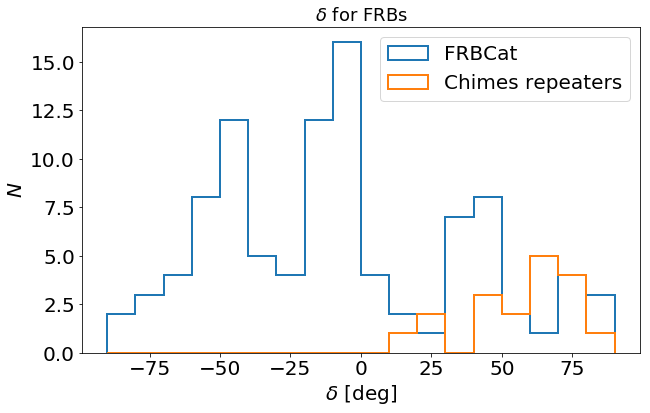

In [23]:
#decl hist
fig, ax = plt.subplots(figsize=(10,6))
dec_bins = np.linspace(-90,90,num=19) #num=19 for every 10 deg

plt.hist(frbs_coord.dec, bins=dec_bins, histtype='step', lw=2., label='FRBCat')
plt.hist(rep_coord.dec, bins=dec_bins, histtype='step', lw=2., label='Chimes repeaters')
plt.legend(loc=0)
ax.set_title(r'$\delta$ for FRBs', fontsize=18)
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel(r'$N$')
plt.show()

In [24]:
dec=frbs['rop_decj'].reindex(frb_ind_all).values
ra=frbs['rop_raj'].reindex(frb_ind_all).values
sources_frbcat=frbs['frb_name'].reindex(frb_ind_all).values

all_decs=np.concatenate((ra_dec[1],dec))
all_ras=np.concatenate((ra_dec[0],ra))
de=[]
n=0
s=0
for d in all_decs:
    if len(d)<7: 
        de.append(d+':00.0')
    else: de.append(d)
    dig=0
    if d[0]=='+'or d[0]=='-': 
        if d[2]==':': dig=2
        else: dig=3
    else: 
        if d[1]==':': dig=1
        else: dig=2
    
    if float(d[0:dig])>-5: n+=1
    elif float(d[0:dig])<=-5: s+=1
    else: print('err')

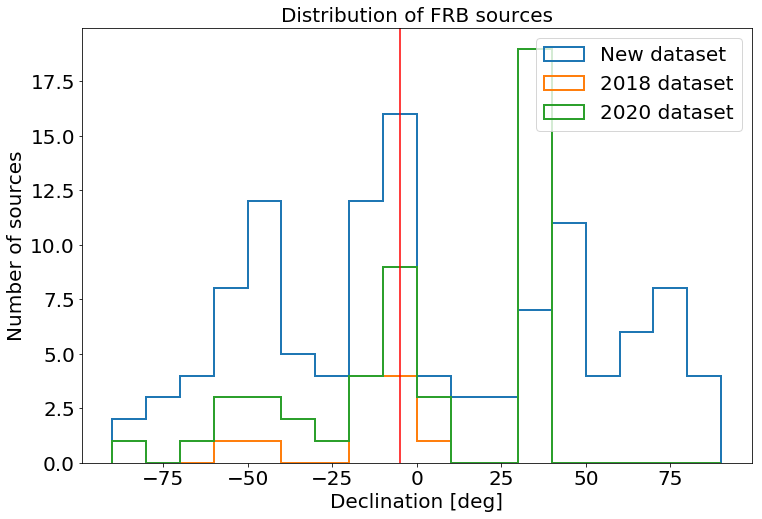

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
dec_bins = np.linspace(-90,90,num=19) #num=19 for every 10 deg

ch_decs=np.concatenate((['-44:44:00'],frbs_cat['rop_decj'][msk].values))
ch_ras=np.concatenate((['21:03:00'],frbs_cat['rop_raj'][msk].values))
ch_coord=SkyCoord(ra=ch_ras, dec=ch_decs, unit=(u.hourangle, u.deg))

new_decs=np.concatenate((['+04:34:00'],frbs_cat['rop_decj'][new_msk].values))
new_ras=np.concatenate((['06:13:00'],frbs_cat['rop_raj'][new_msk].values))
new_coord=SkyCoord(ra=new_ras, dec=new_decs, unit=(u.hourangle, u.deg))

cat_coord=SkyCoord(ra=all_ras, dec=de, unit=(u.hourangle, u.deg))
plt.hist(cat_coord.dec, bins=dec_bins, histtype='step', lw=2., label='New dataset')
plt.hist(ch_coord.dec, bins=dec_bins, histtype='step', lw=2., label='2018 dataset')
plt.hist(new_coord.dec, bins=dec_bins, histtype='step', lw=2., label='2020 dataset')

ax.set_title(r'Distribution of FRB sources', fontsize=20)
plt.legend(loc=0)
plt.xlabel(r'Declination [deg]')
plt.ylabel(r'Number of sources')
plt.axvline(x=-5, c='red')
plt.show()

In [26]:
#saving all sources as csv file
all_names=np.concatenate((rep_num['source'], sources_frbcat))
allfrbs=pd.DataFrame({'frb_name':all_names,'ra':all_ras,'dec':all_decs})
allfrbs.to_csv('./frbs_coord.csv',index=False)

In [20]:
#numbers for table
#col: unique frbs, repeaters, repeats, events
#rows: chime, frbcat,total || 6yr, L2

#unique_frbs, frb_ind_all, n_frbs
frbcat_rep=0
frbcat_rep_events=0
for b in n_frbs:
    if b > 1: 
        frbcat_rep +=1
        frbcat_rep_events +=b

chime_unique_frbs=len(rep_num['source'])
frbcat_unique_frbs=len(unique_frbs)
all_chime_events=sum(rep_num['n_bursts'])
all_frbcat_events=sum(n_frbs)

print('       |frbs | repeaters | repeats | events')
print('frbcat | %i  | %i  | %i  | %i '%(frbcat_unique_frbs,frbcat_rep,frbcat_rep_events,all_frbcat_events))
print('chime  | %i  | %i | %i | %i '%(chime_unique_frbs,chime_unique_frbs,all_chime_events,all_chime_events))
print('total  | %i | %i | %i | %i '%(chime_unique_frbs+frbcat_unique_frbs,chime_unique_frbs+frbcat_rep,
                                     all_chime_events+frbcat_rep_events,all_chime_events+all_frbcat_events))
print('-----------------------------')
print('6yr    | 13  | 1  | 17  | 29 '%(12+17))#%(len(w121102[0]),12+len(w121102[0])))
print('L2     | 29  | 1  | 10  | 39 ')#%(len(w121102[0]),12+len(w121102[0])))
for i in range(len(unique_frbs)): 
    if n_frbs[i]>1:print(unique_frbs[i], n_frbs[i])

       |frbs | repeaters | repeats | events
frbcat | 98  | 3  | 23  | 118 
chime  | 18  | 18 | 172 | 172 
total  | 116 | 21 | 195 | 290 
-----------------------------
6yr    | 13  | 1  | 17  | 29 
L2     | 29  | 1  | 10  | 39 
FRB121102 19
FRB151125 2
FRB180725.J0613+67 2


In [21]:
#total No. events calc 
#98 singe-burst sources from FRBCat
print('6yr events total: ',16+len(ch_decs))
print('2020 events total: ',10+len(new_decs))
print('new events total: ',98+sum(rep_num['n_bursts']))

6yr events total:  47
2020 events total:  56
new events total:  270


In [22]:
#flux hist
#remove nan values
frbs_flux=frbs_flux[~np.isnan(frbs_flux)]
print('Max flux: %.2f'%max(frbs_flux))
print('Min flux: %.4f'%min(frbs_flux))
log_bins_range=[np.log(min(frbs_flux))/np.log(10),np.log(max(frbs_flux))/np.log(10)]
log_bins_range

Max flux: 147.50
Min flux: 0.0200


[-1.6989700043360185, 2.1687920203141817]

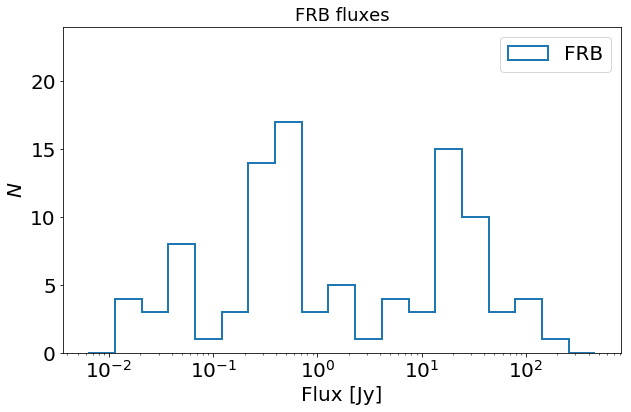

In [23]:
flux_bins=np.logspace(log_bins_range[0]-0.5,log_bins_range[1]+0.5, num=20)
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(frbs_flux, bins=flux_bins, histtype='step', lw=2., label='FRB')

plt.ylabel(r'$N$')
plt.semilogx()
plt.ylim((0,24))
plt.xlabel(r'Flux [Jy]')
plt.legend(loc=0)
ax.set_title(r'FRB fluxes', fontsize=18)
plt.show()

In [24]:
#calculating the time between repeats of a source
deltat=[]
for source in repeaters:
    times=[]
    for event in repeaters[source].keys():
        if 'timestamp' in repeaters[source][event].keys():
            times.append(repeaters[source][event]['timestamp']['value'])
    times = np.asarray([Time(t, format='iso').mjd for t in times])
    times=np.sort(times)
    for i in range(1,len(times)):
        deltat.append(times[i]-times[i-1])
deltat=np.asarray(deltat)
deltat=deltat[deltat.nonzero()]

print('Min time between: ',min(deltat)*365*24*3600,'s')
small_t=np.where(deltat<(1/365))
#for t in np.sort(deltat[small_t]): print('%.2e'%t)

Min time between:  0.08420983795076609 s


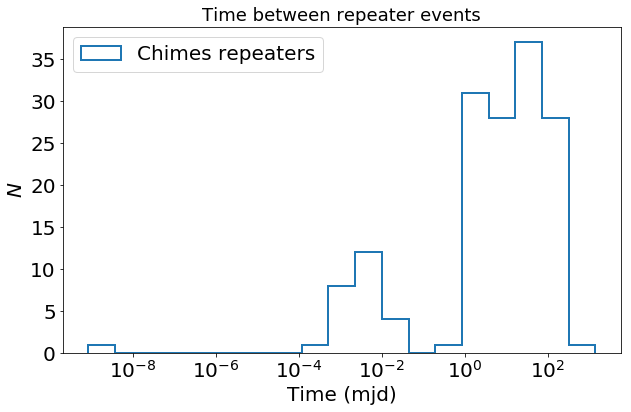

In [25]:
log_bins_range=[(np.log(min(deltat))/np.log(10))-0.5,(np.log(max(deltat))/np.log(10))+0.5]
dt_bins=np.logspace(log_bins_range[0],log_bins_range[1], num=20)
fig, ax = plt.subplots(figsize=(10,6))
#np.histogram(deltat, bins=dt_bins)
plt.hist(deltat, bins=dt_bins, histtype='step', lw=2., label='Chimes repeaters')

plt.ylabel(r'$N$')
plt.semilogx()

plt.xlabel(r'Time (mjd)')
plt.legend(loc=2)
ax.set_title(r'Time between repeater events', fontsize=18)
plt.show()